#HW 10 CLUSTERING BUSINESS

#cluster time trends in NYC businesses: 
#DATA
#Census Business data:
##download census data for businesses by ZIP code. the data is here
http://www.census.gov/econ/cbp/download/
##and it can be downloaded by hand. you can also download it with 3 terminal commands as follows: the data from 1993 through 2001 is different in the format of its path than the data after 2001 (that is why more than one for loop is needed)



In [7]:
%%bash
for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

for ((y=0; y<=1; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0$y\totals.zip; done

for ((y=2; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done


--2015-12-11 20:13:53--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp93totals.zip
           => 'zbp93totals.zip'
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000::9481:4b23
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Econ2001_And_Earlier/CBP_CSV ... done.
==> SIZE zbp93totals.zip ... done.
==> PASV ... done.    ==> RETR zbp93totals.zip ... 
No such file 'zbp93totals.zip'.

--2015-12-11 20:13:53--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp94totals.zip
           => 'zbp94totals.zip'
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000::9481:4b23
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Econ2001_And_Earlier/CBP_CSV ... done.
==> SIZE zbp94totals.zip ... 611524
==> PASV ... done.

#NYC zip codes shape file is here
##http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981


NOTES: 
to read in a zip file without unzipping it you can use the pandas and zipfile packages

In [9]:
import json
import urllib2
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import geopandas as gp
from scipy.cluster.vq import kmeans2
from sklearn.cluster import KMeans
pl.style.use('ggplot')
%pylab inline


Populating the interactive namespace from numpy and matplotlib


you may need to clean your data: for some NYC zip codes there may be no info
    
sanity check: you should have 20 (Ntimestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)

In [75]:
zip_codes = gp.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')
zip_codes = pd.DataFrame({'ZIP': zip_codes['postalCode']}).astype(int).drop_duplicates().sort('ZIP')

IMPORTANT: we talked about the importance of "whitening" your data: dividing each feature by its standard deviation. 
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



In [76]:
import zipfile #i am not giving it a name cause i intend to use it only once

years = range(1994,2014)

for year in years:
    yrs = str(year)[2:]
    fname = 'zbp%stotals.zip' %yrs
    zf = zipfile.ZipFile(fname)
  
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    
    
    try:
        df = pd.DataFrame({year : df['EST'], 'ZIP': df['ZIP']})
    except:
        df = pd.DataFrame({year : df['est'], 'ZIP': df['zip']})
    zip_codes = zip_codes.merge(df,on='ZIP',how='left')  
    
#zip_codes.head()     

In [77]:
zip_codes = zip_codes.dropna()

In [78]:
#sanity check
zip_codes.shape

(230, 21)

TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

In [79]:
#normalize data
data = zip_codes.copy()
data = data.set_index(['ZIP'])


In [80]:

#Normalize across the time series
for i in range(len(data)):
    data.iloc[i] = (data.iloc[i]-np.mean(data.iloc[i]))/np.std(data.iloc[i])


In [81]:
data.shape
data = np.asarray(data)
data

array([[-1.83163152, -1.17325024, -1.26941829, ..., -0.14499183,
        -0.08581149,  0.19529512],
       [-1.7228135 , -1.63190671, -1.37217303, ...,  1.20698241,
         1.31607056,  1.40438001],
       [-1.8725281 , -1.45724969, -1.31996757, ...,  1.22661573,
         1.41537864,  1.63159798],
       ..., 
       [-0.41203569, -0.67616114, -0.78181131, ...,  1.48966751,
         1.38401733,  1.27836715],
       [-0.81500559, -1.36036249, -1.23917207, ...,  1.12404117,
         1.12404117,  1.18463638],
       [-1.54935655, -1.72442508, -1.37428801, ...,  0.72653443,
         1.25174003, -0.32387679]])

In [82]:
dates = list(range(1994,2014))
cluster_count= 4
cluster_centroids, closest_centroids = kmeans2(np.asarray(data), 4, iter=15, minit = 'points')
df = pd.DataFrame(cluster_centroids, columns = dates)    



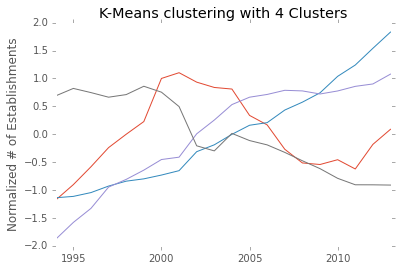

In [83]:
#Plot cluster centroids
for i in range(0,4):
    pl.plot(dates,df.loc[i,dates])
pl.title('K-Means clustering with 4 Clusters')
pl.xlim(1994,2013)
pl.ylabel('Normalized # of Establishments')

In [85]:
#closest_centroids
data = pd.DataFrame(data)
data.columns = dates



In [86]:
data = data.join(pd.Series(closest_centroids, name = 'cluster'))

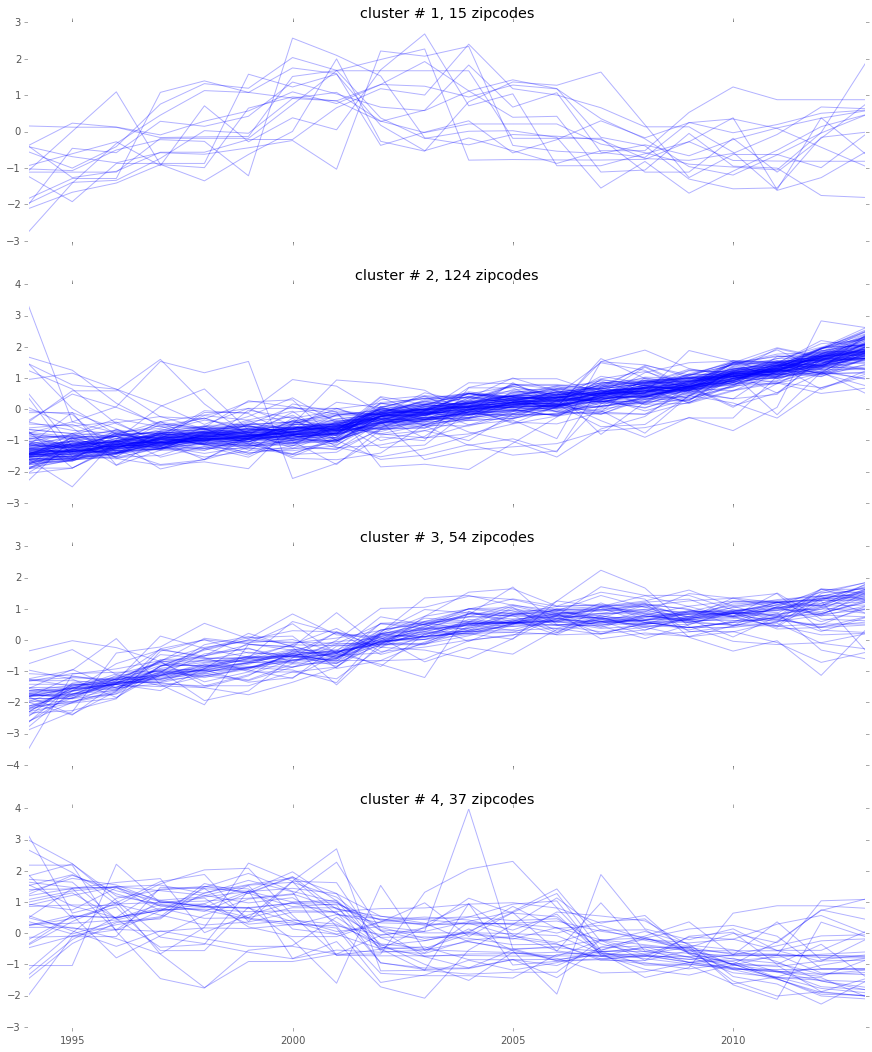

In [130]:
fig, axes = plt.subplots(4, figsize=(15,18))
cmap = cm.get_cmap('Spectral') 

for i,j in data.groupby('cluster'): 
    
    j.iloc[:,:20].T.plot(ax=axes[i],alpha=0.3, legend=0, color = 'b')
    axes[i].set_title('cluster #%d, %d zipcodes'% (i+1, len(j)))

for i, c in enumerate(closest_centroids):
        pd.Series(c).plot(ax=axes[-1], label='cluster %d'% (i ))
   



#Hierarchical Clustering

In [146]:
# Use hierarcical clustering
from scipy.cluster.hierarchy import dendrogram, linkage
#Z = linkage(timeseries_list,metric='euclidean')
Z = linkage(data,'ward')

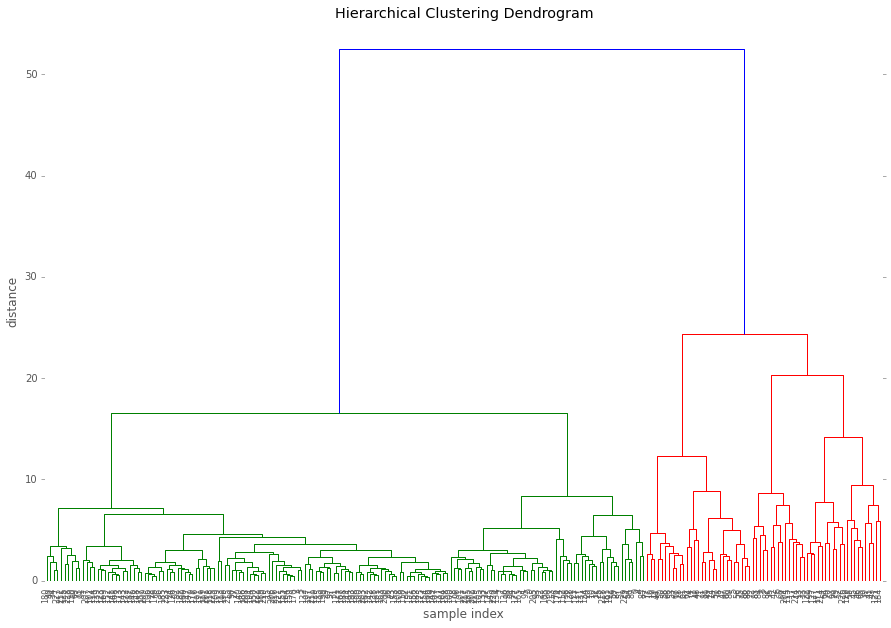

In [152]:
# Plot dendrogram
plt.figure(figsize=(15, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    #truncate_mode='lastp',  # show only the last p merged clusters
    #p=12,  # show only the last p merged clusters
    leaf_font_size=8.,  # font size for the x axis labels
    show_contracted=True
)
plt.show()

In [159]:
from scipy.cluster.hierarchy import fcluster
dis = 15 
h_clusters = fcluster(Z, dis, criterion='distance')

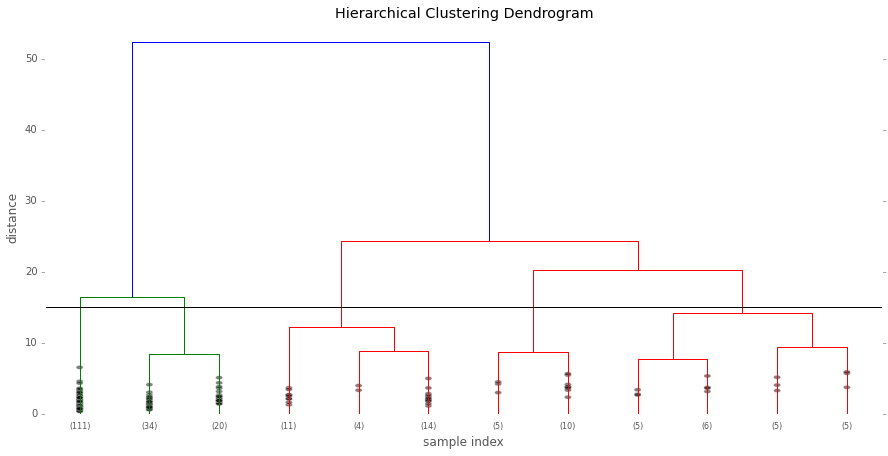

In [160]:
# show truncated dendrogram
plt.figure(figsize=(15, 7))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=12,  # show only the last p merged clusters
    leaf_font_size=8., 
    show_contracted=True
)
plt.axhline(y=dis, c='k')
plt.show()

In [161]:
# Get the unique value from the list of clusters
h_clusters_values = list(set(h_clusters))
print h_clusters_values

[1, 2, 3, 4, 5]


In [169]:
#putting stuff back together
zip_codes = zip_codes.reset_index()
data['ZIP'] = zip_codes['ZIP']

In [175]:
# Find the zipcode index for all the clusters and put it in a dictionary
h_assignments={}
for value in h_clusters_values:
    h_assignments[value]=[i for i, j in enumerate(h_clusters) if j == value] # given a cluster number, find its corresponding zipcode index

In [189]:
data['h_cluster'] = h_clusters
data.head()
h_clusters = data[['ZIP','h_cluster']]
k_clusters = data[['ZIP','h_cluster']]

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2007,2008,2009,2010,2011,2012,2013,cluster,ZIP,h_cluster
0,-1.831632,-1.173250,-1.269418,-0.685012,0.054742,-0.100607,0.520787,-0.433496,-0.781180,-1.202840,...,2.237017,1.667406,0.432016,-0.041426,-0.144992,-0.085811,0.195295,2,10001,10001
1,-1.722813,-1.631907,-1.372173,-1.034519,-1.153997,-0.941015,-0.442326,0.248565,-0.463105,-0.117659,...,0.617387,0.632971,0.851147,1.103089,1.206982,1.316071,1.404380,2,10002,10002
2,-1.872528,-1.457250,-1.319968,-0.914985,-0.523731,-0.489411,-0.407041,-0.685038,-0.636989,-0.334968,...,0.849090,0.924595,1.020693,1.068741,1.226616,1.415379,1.631598,1,10003,10003
3,-1.608897,-1.523770,-1.438643,-1.060302,-1.031926,-0.492790,0.084181,-0.360370,-0.303619,-0.313078,...,0.803030,0.859781,0.888157,1.067869,1.124620,1.484044,1.834010,1,10004,10004
4,-2.885957,-2.304004,-0.417066,-0.223082,0.535220,0.041442,0.835014,0.164887,0.076712,-0.699225,...,0.588125,0.905554,0.605760,0.464681,1.081903,0.588125,0.993729,2,10005,10005


In [263]:
maps = gp.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')
data.ZIP = str(data.ZIP)
#maps.plot()

In [265]:
maps = maps.set_index('postalCode')
data = data.set_index('ZIP')

In [266]:
all_data = maps.join(data)

AttributeError: 'GeoDataFrame' object has no attribute 'joint'

In [259]:
data.dtypes

1994         float64
1995         float64
1996         float64
1997         float64
1998         float64
1999         float64
2000         float64
2001         float64
2002         float64
2003         float64
2004         float64
2005         float64
2006         float64
2007         float64
2008         float64
2009         float64
2010         float64
2011         float64
2012         float64
2013         float64
cluster        int32
ZIP           object
h_cluster      int64
dtype: object

In [260]:
maps.dtypes

@id                object
BLDGpostalCode    float64
CTY_FIPS           object
OBJECTID          float64
PO_NAME            object
STATE              object
ST_FIPS            object
Shape_Area        float64
Shape_Leng        float64
borough            object
geometry           object
ZIP                object
1994_x            float64
1995_x            float64
1996_x            float64
1997_x            float64
1998_x            float64
1999_x            float64
2000_x            float64
2001_x            float64
2002_x            float64
2003_x            float64
2004_x            float64
2005_x            float64
2006_x            float64
2007_x            float64
2008_x            float64
2009_x            float64
2010_x            float64
2011_x            float64
2012_x            float64
2013_x            float64
cluster_x         float64
h_cluster_x       float64
1994_y            float64
1995_y            float64
1996_y            float64
1997_y            float64
1998_y      